In [1]:
# This Block Will Set up Apache Spark in Google Colab for distributed processing (this is important for our big data component)

# Install Java and Spark in Colab
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download Hadoop
!wget -q https://downloads.apache.org/hadoop/common/hadoop-3.3.6/hadoop-3.3.6.tar.gz -O hadoop.tar.gz

# Extract Hadoop
!tar -xzf hadoop.tar.gz

# Download Spark
!wget -q https://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz -O spark.tgz

# Extract Spark
!tar -xzf spark.tgz

# Install findspark for Spark-Python binding
!pip install -q findspark

# Set environment variables for Spark and Hadoop
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["HADOOP_HOME"] = "/content/hadoop-3.3.6"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

import findspark
findspark.init()

from pyspark.sql import SparkSession

# Start Spark session with increased memory to avoid memory issues
spark = (SparkSession.builder
    .appName("CMAPSS_Survival_Analysis")
    .master("local[*]")  # Utilizes all local cores
    .config("spark.driver.memory", "8g")
    .config("spark.executor.memory", "8g")
    .config("spark.driver.memoryOverhead", "2g")
    .config("spark.executor.memoryOverhead", "2g")
    .getOrCreate()
)

# Set log level to reduce verbosity
spark.sparkContext.setLogLevel("ERROR")

# Verify Spark session
spark


In [2]:
# This Block Will Mount Google Drive to access the dataset (this will allow me and my teammate to access and work on the same files collaboratively)

from google.colab import drive
drive.mount('/content/drive')

# Define the path to the dataset (assuming it's saved in a shared folder in your Google Drive)
data_folder = '/content/drive/My Drive/CMAPSSData/'


Mounted at /content/drive


In [3]:
# This Block Will Load All The Training, Test, and RUL Datasets for FD001 to FD004

from pyspark.sql.functions import col

# Load training datasets for FD001 to FD004 and repartition to reduce overhead
train_fd001 = spark.read.csv(data_folder + 'train_FD001.txt', header=False, inferSchema=True, sep=' ').repartition(4)
train_fd002 = spark.read.csv(data_folder + 'train_FD002.txt', header=False, inferSchema=True, sep=' ').repartition(4)
train_fd003 = spark.read.csv(data_folder + 'train_FD003.txt', header=False, inferSchema=True, sep=' ').repartition(4)
train_fd004 = spark.read.csv(data_folder + 'train_FD004.txt', header=False, inferSchema=True, sep=' ').repartition(4)

# Inspect the schema to confirm the number of columns
print("Schema of FD001 training dataset:")
train_fd001.printSchema()

# Define column names based on the expected columns
expected_columns = ['unit_number', 'time_in_cycles', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + \
                   [f'sensor_{i}' for i in range(1, 22)]

# Drop extra columns dynamically based on the schema and rename for training sets
train_fd001 = train_fd001.drop(*[c for c in train_fd001.columns[len(expected_columns):]]).toDF(*expected_columns)
train_fd002 = train_fd002.drop(*[c for c in train_fd002.columns[len(expected_columns):]]).toDF(*expected_columns)
train_fd003 = train_fd003.drop(*[c for c in train_fd003.columns[len(expected_columns):]]).toDF(*expected_columns)
train_fd004 = train_fd004.drop(*[c for c in train_fd004.columns[len(expected_columns):]]).toDF(*expected_columns)

# Show the first few rows of each training dataset to verify the loaded data
print("Training Dataset FD001:")
train_fd001.show(5)

print("Training Dataset FD002:")
train_fd002.show(5)

print("Training Dataset FD003:")
train_fd003.show(5)

print("Training Dataset FD004:")
train_fd004.show(5)

# Load test datasets for FD001 to FD004 and repartition
test_fd001 = spark.read.csv(data_folder + 'test_FD001.txt', header=False, inferSchema=True, sep=' ').repartition(4)
test_fd002 = spark.read.csv(data_folder + 'test_FD002.txt', header=False, inferSchema=True, sep=' ').repartition(4)
test_fd003 = spark.read.csv(data_folder + 'test_FD003.txt', header=False, inferSchema=True, sep=' ').repartition(4)
test_fd004 = spark.read.csv(data_folder + 'test_FD004.txt', header=False, inferSchema=True, sep=' ').repartition(4)

test_fd001 = test_fd001.drop(*[c for c in test_fd001.columns[len(expected_columns):]]).toDF(*expected_columns)
test_fd002 = test_fd002.drop(*[c for c in test_fd002.columns[len(expected_columns):]]).toDF(*expected_columns)
test_fd003 = test_fd003.drop(*[c for c in test_fd003.columns[len(expected_columns):]]).toDF(*expected_columns)
test_fd004 = test_fd004.drop(*[c for c in test_fd004.columns[len(expected_columns):]]).toDF(*expected_columns)

# Show the first few rows of each test dataset
print("Test Dataset FD001:")
test_fd001.show(5)

print("Test Dataset FD002:")
test_fd002.show(5)

print("Test Dataset FD003:")
test_fd003.show(5)

print("Test Dataset FD004:")
test_fd004.show(5)

# Load RUL files for FD001 to FD004 and repartition to minimal partitions (they are small)
rul_fd001 = spark.read.csv(data_folder + 'RUL_FD001.txt', header=False, inferSchema=True).withColumnRenamed('_c0', 'RUL').repartition(1)
rul_fd002 = spark.read.csv(data_folder + 'RUL_FD002.txt', header=False, inferSchema=True).withColumnRenamed('_c0', 'RUL').repartition(1)
rul_fd003 = spark.read.csv(data_folder + 'RUL_FD003.txt', header=False, inferSchema=True).withColumnRenamed('_c0', 'RUL').repartition(1)
rul_fd004 = spark.read.csv(data_folder + 'RUL_FD004.txt', header=False, inferSchema=True).withColumnRenamed('_c0', 'RUL').repartition(1)

# Show the first few rows of each RUL file to verify the loaded data
print("RUL Dataset FD001:")
rul_fd001.show(5)

print("RUL Dataset FD002:")
rul_fd002.show(5)

print("RUL Dataset FD003:")
rul_fd003.show(5)

print("RUL Dataset FD004:")
rul_fd004.show(5)


Schema of FD001 training dataset:
root
 |-- _c0: integer (nullable = true)
 |-- _c1: integer (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: double (nullable = true)
 |-- _c8: double (nullable = true)
 |-- _c9: double (nullable = true)
 |-- _c10: double (nullable = true)
 |-- _c11: double (nullable = true)
 |-- _c12: double (nullable = true)
 |-- _c13: double (nullable = true)
 |-- _c14: double (nullable = true)
 |-- _c15: double (nullable = true)
 |-- _c16: double (nullable = true)
 |-- _c17: double (nullable = true)
 |-- _c18: double (nullable = true)
 |-- _c19: double (nullable = true)
 |-- _c20: double (nullable = true)
 |-- _c21: integer (nullable = true)
 |-- _c22: integer (nullable = true)
 |-- _c23: double (nullable = true)
 |-- _c24: double (nullable = true)
 |-- _c25: double (nullable = true)
 |-- _c26: string (nullable = t

In [4]:
# This Block Will Calculate The RUL Value For Training Subsets & Join The RUL Value From The Respective File With The Test Subsets

from pyspark.sql.functions import max as spark_max, col, monotonically_increasing_id

# Preprocess Training Datasets
def calculate_rul(training_df):
    # Calculate max(time_in_cycles) for each engine
    max_cycles = training_df.groupBy("unit_number").agg(spark_max("time_in_cycles").alias("max_time_in_cycles"))
    # Join back to calculate RUL
    training_with_rul = training_df.join(max_cycles, on="unit_number")
    training_with_rul = training_with_rul.withColumn("RUL", col("max_time_in_cycles") - col("time_in_cycles"))
    return training_with_rul.drop("max_time_in_cycles")

# Apply the function to training datasets
train_fd001 = calculate_rul(train_fd001)
train_fd002 = calculate_rul(train_fd002)
train_fd003 = calculate_rul(train_fd003)
train_fd004 = calculate_rul(train_fd004)

# Add unit_number to RUL DataFrames
def add_unit_number(rul_df):
    return rul_df.withColumn("unit_number", monotonically_increasing_id())

rul_fd001 = add_unit_number(rul_fd001)
rul_fd002 = add_unit_number(rul_fd002)
rul_fd003 = add_unit_number(rul_fd003)
rul_fd004 = add_unit_number(rul_fd004)

# Preprocess Test Datasets
def join_rul(test_df, rul_df):
    return test_df.join(rul_df, on="unit_number")

test_fd001 = join_rul(test_fd001, rul_fd001)
test_fd002 = join_rul(test_fd002, rul_fd002)
test_fd003 = join_rul(test_fd003, rul_fd003)
test_fd004 = join_rul(test_fd004, rul_fd004)

# Function to display the first 10 rows of a DataFrame
def show_first_rows(df, name):
    print(f"First 10 rows of {name}:")
    df.show(10)

# Display the first 10 rows for training datasets
show_first_rows(train_fd001, "Training Dataset FD001")
show_first_rows(train_fd002, "Training Dataset FD002")
show_first_rows(train_fd003, "Training Dataset FD003")
show_first_rows(train_fd004, "Training Dataset FD004")

# Display the first 10 rows for test datasets
show_first_rows(test_fd001, "Test Dataset FD001")
show_first_rows(test_fd002, "Test Dataset FD002")
show_first_rows(test_fd003, "Test Dataset FD003")
show_first_rows(test_fd004, "Test Dataset FD004")

# Validation checks
print("Validation FD001:")
print(f"Unique units in test_fd001: {test_fd001.select('unit_number').distinct().count()}")
print(f"Rows in rul_fd001: {rul_fd001.count()}")

print("Validation FD002:")
print(f"Unique units in test_fd002: {test_fd002.select('unit_number').distinct().count()}")
print(f"Rows in rul_fd002: {rul_fd002.count()}")

print("Validation FD003:")
print(f"Unique units in test_fd003: {test_fd003.select('unit_number').distinct().count()}")
print(f"Rows in rul_fd003: {rul_fd003.count()}")

print("Validation FD004:")
print(f"Unique units in test_fd004: {test_fd004.select('unit_number').distinct().count()}")
print(f"Rows in rul_fd004: {rul_fd004.count()}")


First 10 rows of Training Dataset FD001:
+-----------+--------------+---------------------+---------------------+---------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---+
|unit_number|time_in_cycles|operational_setting_1|operational_setting_2|operational_setting_3|sensor_1|sensor_2|sensor_3|sensor_4|sensor_5|sensor_6|sensor_7|sensor_8|sensor_9|sensor_10|sensor_11|sensor_12|sensor_13|sensor_14|sensor_15|sensor_16|sensor_17|sensor_18|sensor_19|sensor_20|sensor_21|RUL|
+-----------+--------------+---------------------+---------------------+---------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---+
|         56|             5|               0.0034|         

In [5]:
# PREPROCESSING & FEATURE ENGINEERING BLOCK
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

drop_cols = [
    'operational_setting_1', 'operational_setting_2', 'operational_setting_3',
    'sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19'
]

scaler_params = {}

def feature_engineering(pd_data):
    # Polynomial and interaction features
    if 'sensor_2' in pd_data.columns:
        pd_data['sensor_2_square'] = pd_data['sensor_2'] ** 2
    if 'sensor_4' in pd_data.columns:
        pd_data['sensor_4_square'] = pd_data['sensor_4'] ** 2
    if 'sensor_11' in pd_data.columns:
        pd_data['sensor_11_square'] = pd_data['sensor_11'] ** 2
    if 'sensor_15' in pd_data.columns:
        pd_data['sensor_15_square'] = pd_data['sensor_15'] ** 2

    if 'sensor_2' in pd_data.columns and 'sensor_3' in pd_data.columns:
        pd_data['sensor_2_x_sensor_3'] = pd_data['sensor_2'] * pd_data['sensor_3']
    if 'sensor_11' in pd_data.columns and 'sensor_15' in pd_data.columns:
        pd_data['sensor_11_x_sensor_15'] = pd_data['sensor_11'] * pd_data['sensor_15']
    return pd_data

def prepare_training_data(train_df, subset_name):
    pd_data = train_df.select(
        "unit_number",
        "operational_setting_1",
        "operational_setting_2",
        "operational_setting_3",
        *[f"sensor_{i}" for i in range(1, 22)],
        "RUL"
    ).toPandas()

    pd_data = pd_data[pd_data['RUL'] > 0]
    pd_data['event'] = 1
    pd_data['weights'] = 1 / (pd_data['RUL'] + 1)

    pd_data = pd_data.drop(columns=drop_cols, errors='ignore')
    pd_data = feature_engineering(pd_data)

    exclude = {'unit_number', 'event', 'weights', 'RUL'}
    sensor_cols = [c for c in pd_data.columns if c not in exclude]

    # Apply Z-score normalization
    scaler = StandardScaler()
    pd_data[sensor_cols] = scaler.fit_transform(pd_data[sensor_cols])

    scaler_params[subset_name] = {
        'mean': scaler.mean_,
        'scale': scaler.scale_,
        'columns': sensor_cols
    }
    return pd_data

def prepare_test_data(test_df, subset_name):
    pd_test = test_df.select(
        "unit_number",
        "operational_setting_1",
        "operational_setting_2",
        "operational_setting_3",
        *[f"sensor_{i}" for i in range(1,22)],
        "RUL"
    ).toPandas()

    pd_test = pd_test[pd_test['RUL'] > 0]
    pd_test['event'] = 1
    pd_test = pd_test.drop(columns=drop_cols, errors='ignore')
    pd_test = feature_engineering(pd_test)

    params = scaler_params[subset_name]
    sensor_cols = params['columns']
    mean = params['mean']
    scale = params['scale']

    pd_test[sensor_cols] = (pd_test[sensor_cols] - mean) / scale
    return pd_test


**Then We Will Go To Training**


In [6]:
# MODEL TRAINING BLOCK
!pip install lifelines
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

def train_cox_model_with_tuning(pd_data, penalizers=[0.001, 0.01, 0.1, 1.0]):
    n = len(pd_data)
    train_df = pd_data.iloc[:int(0.8*n)]
    val_df = pd_data.iloc[int(0.8*n):]

    best_c_index = -np.inf
    best_model = None
    best_penalizer = None

    for p in penalizers:
        cph = CoxPHFitter(penalizer=p)
        cph.fit(train_df, duration_col='RUL', event_col='event', weights_col='weights', robust=True)

        medians = cph.predict_median(val_df)
        val_actual = val_df['RUL'].values
        val_event = val_df['event'].values

        val_c_index = concordance_index(val_actual, medians, event_observed=val_event)
        if val_c_index > best_c_index:
            best_c_index = val_c_index
            best_model = cph
            best_penalizer = p

    print(f"Selected penalizer: {best_penalizer}, Validation C-index: {best_c_index:.2f}")
    return best_model

def train_all_cox_models():
    print("Training Cox model for FD001...")
    cox_data_fd001 = prepare_training_data(train_fd001, "FD001")
    cox_model_fd001 = train_cox_model_with_tuning(cox_data_fd001)
    print("Cox Model for FD001 trained.\n")

    print("Training Cox model for FD002...")
    cox_data_fd002 = prepare_training_data(train_fd002, "FD002")
    cox_model_fd002 = train_cox_model_with_tuning(cox_data_fd002)
    print("Cox Model for FD002 trained.\n")

    print("Training Cox model for FD003...")
    cox_data_fd003 = prepare_training_data(train_fd003, "FD003")
    cox_model_fd003 = train_cox_model_with_tuning(cox_data_fd003)
    print("Cox Model for FD003 trained.\n")

    print("Training Cox model for FD004...")
    cox_data_fd004 = prepare_training_data(train_fd004, "FD004")
    cox_model_fd004 = train_cox_model_with_tuning(cox_data_fd004)
    print("Cox Model for FD004 trained.\n")

    return cox_model_fd001, cox_model_fd002, cox_model_fd003, cox_model_fd004

# Train all models
cox_model_fd001, cox_model_fd002, cox_model_fd003, cox_model_fd004 = train_all_cox_models()


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 8.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=72ba9f1688e14636e301214786f0460c402a98d600c84e1fc85edd976b67e4f7
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
Training Cox model for FD001...
Selected penalizer: 0.001, Validation C-index: 0.80
Cox Model for FD001 trained.

Training Cox model for FD002...
Selected penalizer: 0.001, Validation C-index: 0.74
Cox Model for FD002 trained.

Training Cox model for FD003...
Selected penalizer: 0.1, Validation C-index: 0.82
Cox Model for FD003 trained.

Training Cox model for FD004...
Selected penalizer: 0.001, Validation C-index: 0.71
Cox Model for FD004 trained.



**Then We Will Do The Prediction**

In [7]:
# PREDICTION BLOCK

def cox_predict_median_rul(cox_model, pd_test):
    predicted_medians = cox_model.predict_median(pd_test)
    # Replace infinities with a large finite number
    # For example, 2000 cycles or max actual RUL + margin
    predicted_medians = np.where(np.isfinite(predicted_medians), predicted_medians, 2000)
    pd_test['predicted_RUL'] = predicted_medians
    return pd_test

# Predict for all subsets
cox_test_fd001 = cox_predict_median_rul(cox_model_fd001, prepare_test_data(test_fd001, "FD001"))
cox_test_fd002 = cox_predict_median_rul(cox_model_fd002, prepare_test_data(test_fd002, "FD002"))
cox_test_fd003 = cox_predict_median_rul(cox_model_fd003, prepare_test_data(test_fd003, "FD003"))
cox_test_fd004 = cox_predict_median_rul(cox_model_fd004, prepare_test_data(test_fd004, "FD004"))

print("Cox predictions completed for all subsets.")
print("Cox Predictions FD001 (first 10 rows):")
display(cox_test_fd001.head(10))
print("Cox Predictions FD002 (first 10 rows):")
display(cox_test_fd002.head(10))
print("Cox Predictions FD003 (first 10 rows):")
display(cox_test_fd003.head(10))
print("Cox Predictions FD004 (first 10 rows):")
display(cox_test_fd004.head(10))


Cox predictions completed for all subsets.
Cox Predictions FD001 (first 10 rows):


,unit_number,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,...,sensor_21,RUL,event,sensor_2_square,sensor_4_square,sensor_11_square,sensor_15_square,sensor_2_x_sensor_3,sensor_11_x_sensor_15,predicted_RUL
0,70,0.270688,-0.056700,0.197273,0.368399,-0.654543,-0.650673,-0.750656,0.230591,-0.075932,...,0.313992,118.0,1,0.270299,0.193984,-0.750929,0.004627,-0.002280,-0.442350,121.0
1,82,-0.919938,-1.072986,-0.552172,0.128525,-1.509731,-0.222646,-0.826458,0.669692,-0.779747,...,1.485270,137.0,1,-0.919890,-0.553630,-0.826305,-0.932513,-1.111486,-0.925223,196.0
2,36,0.936632,0.278774,0.531485,-0.191308,0.200645,-0.417246,0.386371,-0.016404,0.627884,...,-0.888084,21.0,1,0.936475,0.528520,0.383531,0.370867,0.412900,0.401342,58.0
3,39,-1.343720,-1.482461,-1.322998,1.065178,-0.797074,-0.286896,-1.167566,1.479286,-1.483563,...,1.191284,28.0,1,-1.343253,-1.318880,-1.165102,-0.921794,-1.548025,-1.120926,273.0
4,49,0.149608,0.102815,0.595626,-1.413525,0.200645,-0.339591,1.144389,-0.441784,0.346358,...,-1.285666,79.0,1,0.149213,0.592804,1.143818,0.023463,0.117083,0.686238,48.0
5,64,-1.020839,-0.729291,-0.686082,0.459780,-0.797074,-0.281812,-0.333746,0.354088,-0.357458,...,1.177285,128.0,1,-1.020703,-0.686840,-0.335792,-0.672437,-0.826010,-0.513209,160.0
6,79,-0.334715,-1.229212,-1.468161,0.048567,-1.082137,-0.689038,-0.902259,0.203147,-0.779747,...,0.596779,90.0,1,-0.335018,-1.462574,-0.901648,0.066523,-1.145628,-0.503068,180.0
7,84,-1.565702,0.137349,-0.082925,0.391245,-0.369480,-0.505532,-0.826458,0.875521,-0.216695,...,0.051738,118.0,1,-1.564960,-0.085943,-0.826305,-0.449659,-0.158151,-0.699277,150.0
8,22,0.371589,-0.448085,0.092620,-0.739592,-0.226949,-1.098113,-0.295845,0.216869,-0.216695,...,0.972895,113.0,1,0.371213,0.089375,-0.298005,-0.366397,-0.330154,-0.347359,115.0
9,52,-0.637417,-0.038610,-0.495908,-0.054237,-1.224668,1.453405,-0.561151,0.258035,-1.061274,...,0.157200,26.0,1,-0.637571,-0.497625,-0.562350,-0.277729,-0.148053,-0.462377,114.0


Cox Predictions FD002 (first 10 rows):


,unit_number,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,...,sensor_21,RUL,event,sensor_2_square,sensor_4_square,sensor_11_square,sensor_15_square,sensor_2_x_sensor_3,sensor_11_x_sensor_15,predicted_RUL
0,30,-0.628038,-0.570391,-0.724256,-0.604071,-0.039442,-0.508539,-0.368256,-0.597847,0.419080,...,-0.606275,75.0,1,-0.638408,-0.731667,-0.408760,-0.093422,-0.614274,-1.500470,154.0
1,1,0.759850,0.669034,0.459899,0.350462,0.656345,0.686225,0.488199,0.348210,0.421342,...,0.358174,79.0,1,0.735757,0.411877,0.468694,-0.078147,0.689797,2.227392,9.0
2,142,-1.143938,-1.478825,-1.263539,-0.736919,-2.157898,-1.555796,-1.861643,-0.740929,-2.389515,...,-0.649828,81.0,1,-1.118058,-1.207511,-1.804101,2.198195,-1.290117,0.811275,32.0
3,17,0.743762,0.616196,0.367655,0.358547,0.654556,0.591220,0.370707,0.357511,0.418769,...,0.375152,99.0,1,0.719128,0.317925,0.344990,-0.240936,0.652507,0.918551,62.0
4,24,-0.651098,-0.586337,-0.635537,-0.601262,-0.039855,-0.505146,-0.346613,-0.605768,0.419236,...,-0.594229,88.0,1,-0.660208,-0.650690,-0.387280,-0.061961,-0.632570,-1.261400,115.0
5,68,-0.805547,-0.659178,-0.685226,-0.981787,-0.115322,-0.584079,-0.260040,-0.983929,0.418691,...,-1.048899,115.0,1,-0.805348,-0.696137,-0.300998,-0.014804,-0.737287,-0.670518,43.0
6,174,-0.655120,-0.522271,-0.608510,-0.606811,-0.039649,-0.498747,-0.355889,-0.603225,0.419003,...,-0.614823,142.0,1,-0.664007,-0.625871,-0.396490,-0.024404,-0.601612,-1.126469,103.0
7,70,0.671901,0.790845,0.747125,0.767985,0.619677,0.717953,0.667529,0.768155,0.418379,...,0.787232,148.0,1,0.645051,0.709688,0.659549,-0.888356,0.715120,-1.233204,133.0
8,75,0.735450,0.562038,0.321574,0.365056,0.654281,0.598720,0.373799,0.359328,0.418145,...,0.371013,36.0,1,0.710542,0.271300,0.348232,-0.204831,0.618262,1.111616,53.0
9,183,1.671524,1.572373,1.626344,1.858654,1.095460,1.634994,1.384849,1.858892,0.418301,...,1.834901,191.0,1,1.704904,1.670905,1.447649,-1.113035,1.663323,0.318587,47.0


Cox Predictions FD003 (first 10 rows):


,unit_number,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,...,sensor_21,RUL,event,sensor_2_square,sensor_4_square,sensor_11_square,sensor_15_square,sensor_2_x_sensor_3,sensor_11_x_sensor_15,predicted_RUL
0,78,-1.047814,-1.447145,-0.304460,-0.173431,-0.638463,-0.725216,-0.278474,-0.157372,-0.576001,...,-0.063373,18.0,1,-1.047593,-0.306969,-0.280816,-0.611447,-1.455665,-0.596752,112.0
1,21,-0.816351,-1.130070,-0.917116,0.195313,-0.511157,-0.046696,-0.548179,0.219640,-0.384837,...,0.702113,119.0,1,-0.816345,-0.915836,-0.549303,-0.174941,-1.136693,-0.456512,106.0
2,17,0.128789,-0.177363,-1.056826,-0.211780,-0.383852,-0.137369,-0.784171,-0.216572,-0.576001,...,0.054394,132.0,1,0.128370,-1.054321,-0.783857,-0.506610,-0.135748,-0.832479,99.0
3,1,-0.430580,-1.128588,-0.984384,-0.214730,-0.638463,-0.244853,-1.222441,-0.057666,-0.129953,...,1.199577,51.0,1,-0.430834,-0.982531,-1.218535,-0.489962,-1.070892,-1.088857,126.0
4,86,1.054641,0.401966,1.889512,-0.595274,-0.192893,0.586996,0.227223,-0.403520,-0.066232,...,-0.233255,68.0,1,1.054504,1.894575,0.223822,0.885309,0.532626,0.759241,26.0
5,24,-0.893506,-0.506291,-0.918151,-0.418277,-0.574810,-0.189838,-0.817884,-0.359899,-0.384837,...,-0.841042,58.0,1,-0.893432,-0.916862,-0.817336,0.175917,-0.598134,-0.377741,106.0
6,95,0.244521,-0.586301,-0.755673,0.103865,-0.447505,-0.225495,-0.784171,0.188482,0.124932,...,0.780624,113.0,1,0.244099,-0.755641,-0.783857,-0.103170,-0.478179,-0.551161,91.0
7,97,-0.565600,-0.017344,-0.435891,-0.297329,-0.511157,-0.442499,-1.087589,-0.095056,-0.639722,...,0.298050,17.0,1,-0.565776,-0.437804,-1.084916,-0.486633,-0.110799,-1.004074,107.0
8,98,0.784601,-0.196624,0.759409,-0.474326,0.252678,-0.951899,0.058657,-0.680827,0.570980,...,-0.068111,8.0,1,0.784310,0.756444,0.055432,0.422040,-0.042719,0.332608,51.0
9,57,0.321675,-0.012899,0.288533,-0.639524,-0.001934,-0.896374,0.260936,-0.353667,0.252374,...,-1.167270,40.0,1,0.321258,0.284812,0.257522,0.428743,0.042168,0.461789,50.0


Cox Predictions FD004 (first 10 rows):


,unit_number,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,...,sensor_21,RUL,event,sensor_2_square,sensor_4_square,sensor_11_square,sensor_15_square,sensor_2_x_sensor_3,sensor_11_x_sensor_15,predicted_RUL
0,17,-0.796553,-0.661280,-0.729143,-0.980746,-0.114261,-0.576278,-0.351525,-0.980625,0.419109,...,-1.013403,104.0,1,-0.796784,-0.736109,-0.392300,-0.053407,-0.734307,-1.198619,58.0
1,149,-0.647951,-0.587375,-0.696889,-0.610315,-0.039562,-0.543173,-0.413142,-0.609248,0.417707,...,-0.590396,57.0,1,-0.657124,-0.706788,-0.453315,-0.034778,-0.631661,-1.370159,130.0
2,20,-1.136062,-1.489005,-1.256854,-0.736039,-2.153671,-1.542466,-1.848815,-0.737832,-2.385488,...,-0.673564,91.0,1,-1.110600,-1.201478,-1.791978,2.230258,-1.291863,0.942322,26.0
3,107,0.671798,0.791194,0.978483,0.759443,0.620633,0.762432,0.806873,0.757500,0.419966,...,0.763556,153.0,1,0.644771,0.955229,0.809336,-0.823905,0.715214,-0.316135,30.0
4,177,0.742217,0.628323,0.356942,0.344198,0.655199,0.634965,0.449495,0.346825,0.419577,...,0.383047,106.0,1,0.717347,0.306821,0.427567,-0.151174,0.658386,1.645368,28.0
5,153,-0.791734,-0.635013,-0.717330,-0.984832,-0.113574,-0.579481,-0.317636,-0.983803,0.420590,...,-1.033939,34.0,1,-0.792277,-0.725382,-0.358617,0.019747,-0.718902,-0.729660,34.0
6,131,0.760424,0.611094,0.364649,0.346581,0.655749,0.613014,0.446414,0.346031,0.419733,...,0.366353,116.0,1,0.736163,0.314632,0.424319,-0.155978,0.657494,1.609593,35.0
7,44,0.741146,0.608647,0.326782,0.357478,0.655268,0.617493,0.360150,0.362284,0.419655,...,0.396000,85.0,1,0.716240,0.276312,0.333666,-0.210072,0.646869,0.996359,60.0
8,67,0.684918,0.821133,0.922017,0.751270,0.620976,0.734340,0.819196,0.752516,0.420044,...,0.775720,46.0,1,0.658269,0.894772,0.822676,-0.769184,0.738277,0.018508,30.0
9,23,-0.639918,-0.440697,-0.562427,-0.609974,-0.037776,-0.502681,-0.185159,-0.603758,0.420590,...,-0.602526,142.0,1,-0.649535,-0.583463,-0.226096,0.063702,-0.553086,0.020238,29.0


**Then We Will Do The Evaluation & Visualization**

FD001 - C-Index: 0.52, MAE: 92.91, RMSE: 130.68


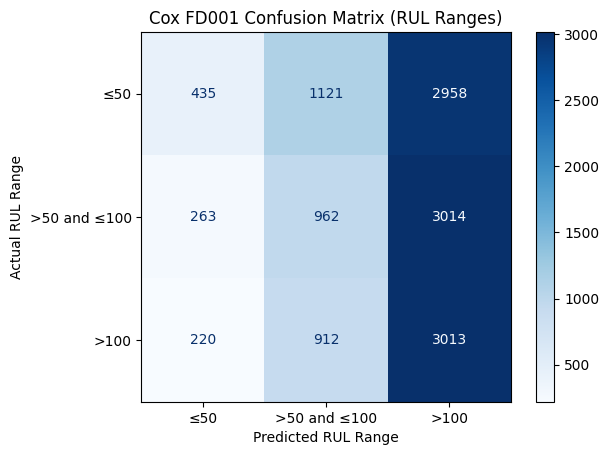

FD002 - C-Index: 0.49, MAE: 55.56, RMSE: 68.23


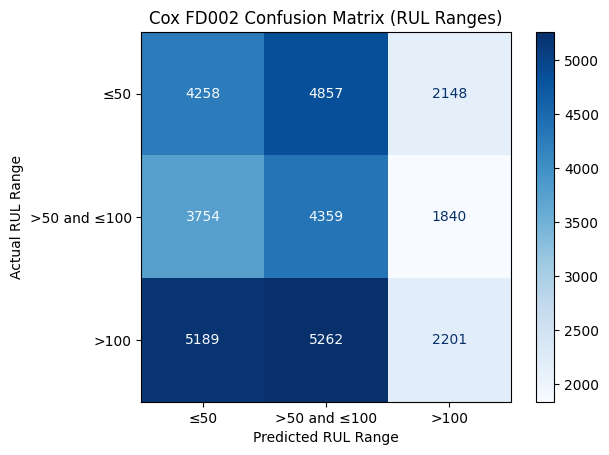

FD003 - C-Index: 0.48, MAE: 51.77, RMSE: 62.66


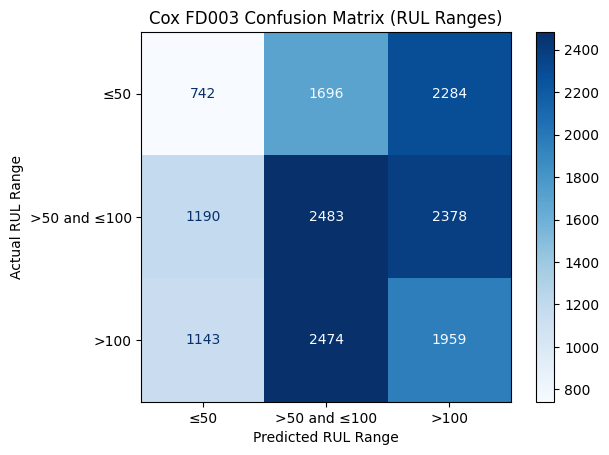

FD004 - C-Index: 0.50, MAE: 55.99, RMSE: 69.14


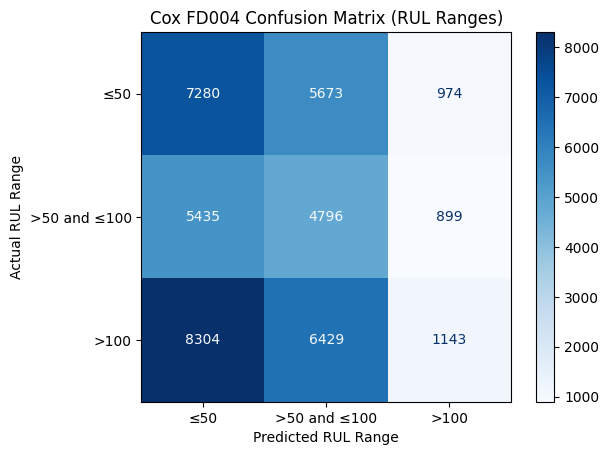

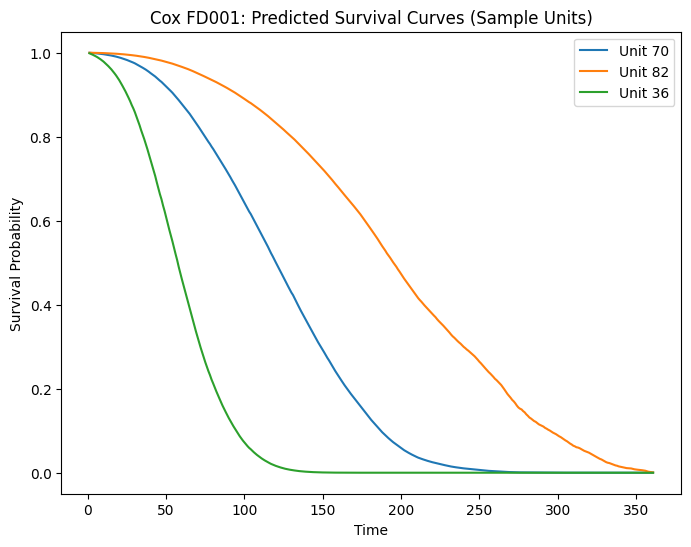

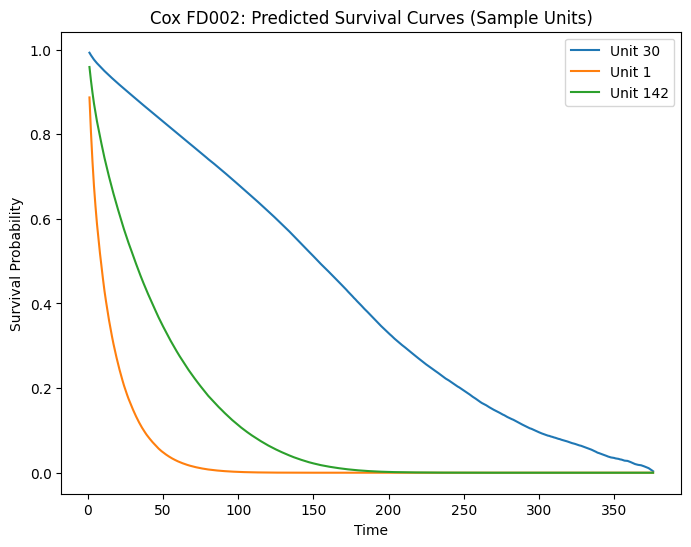

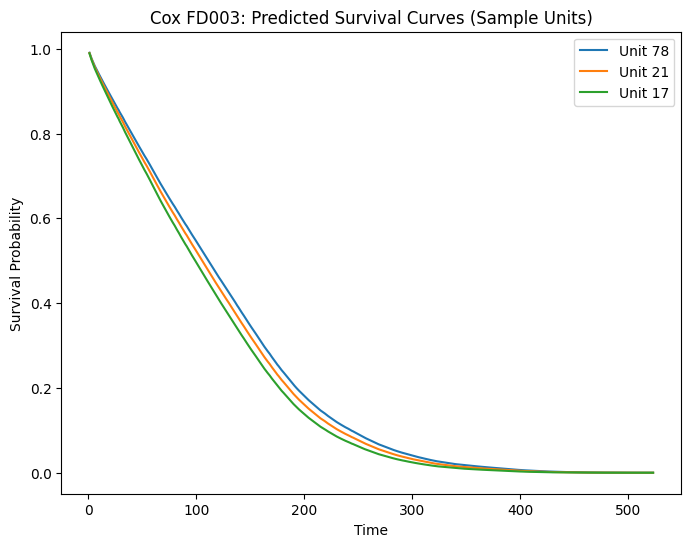

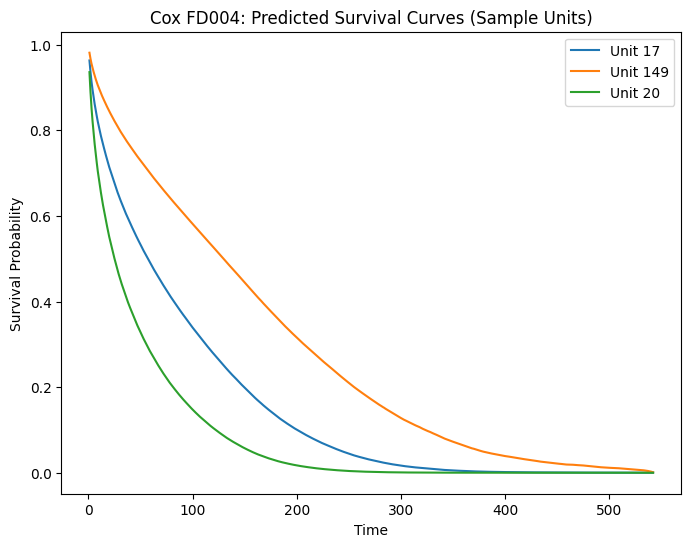

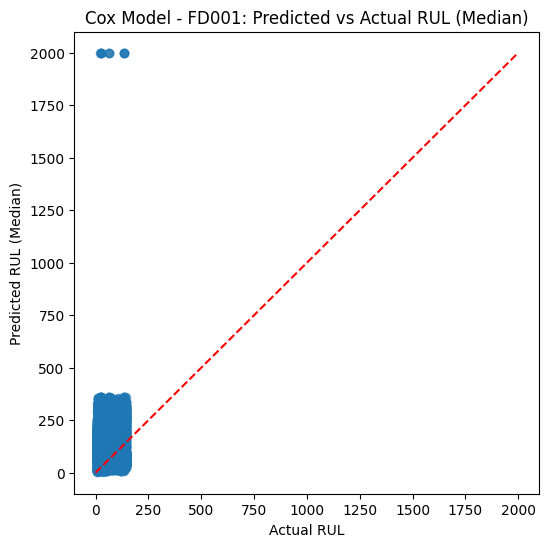

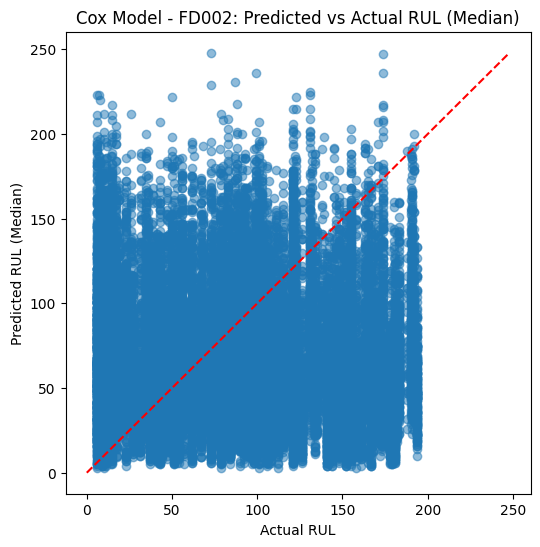

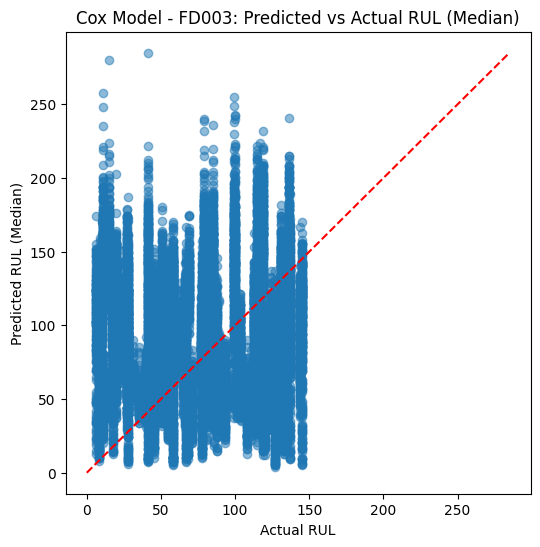

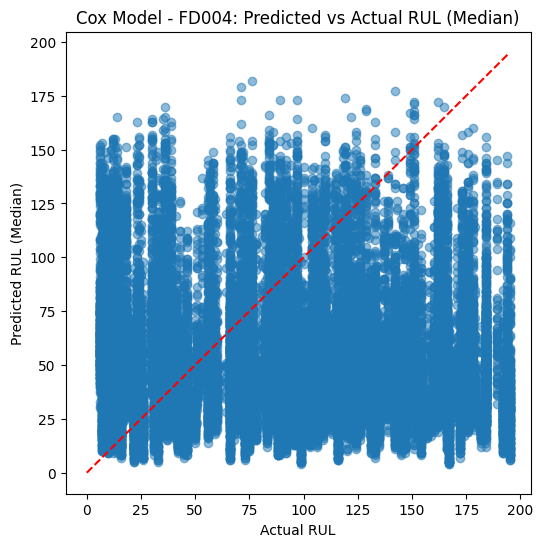

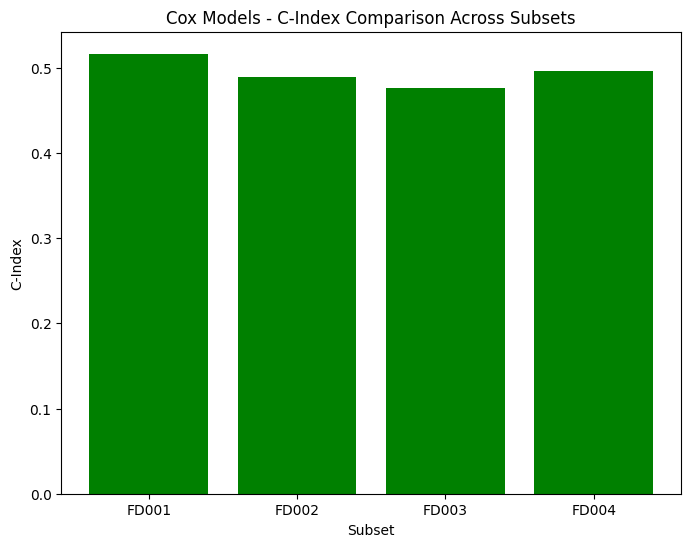

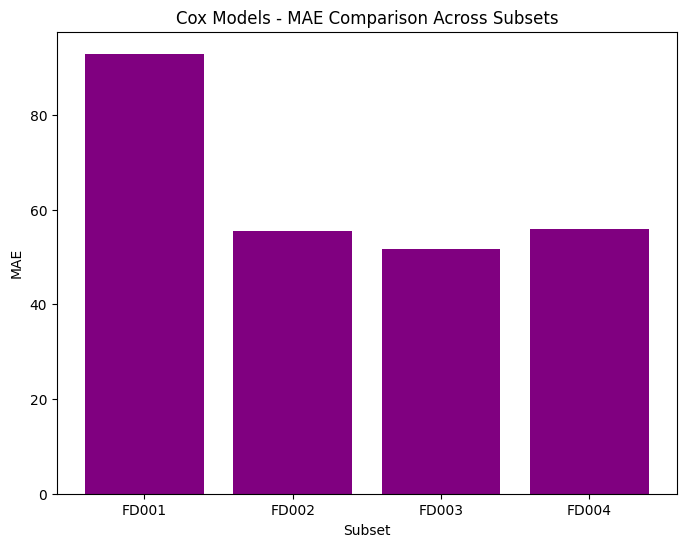

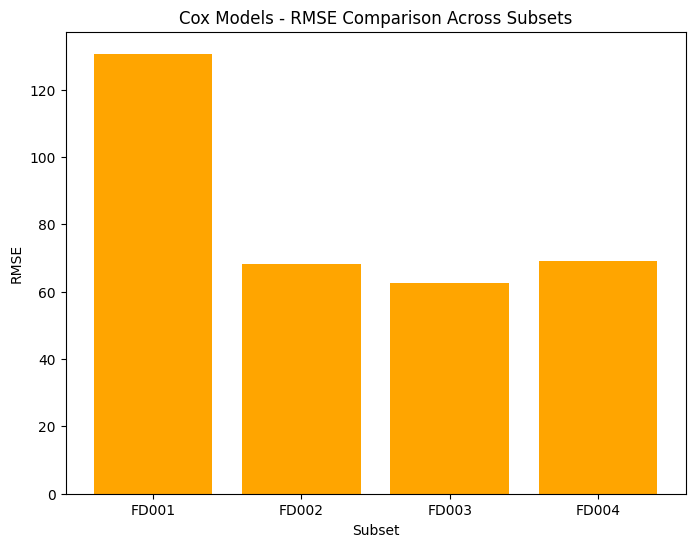

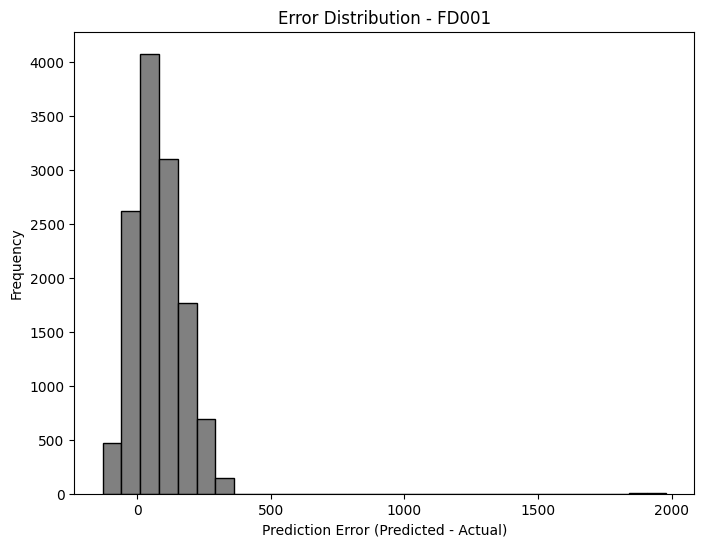

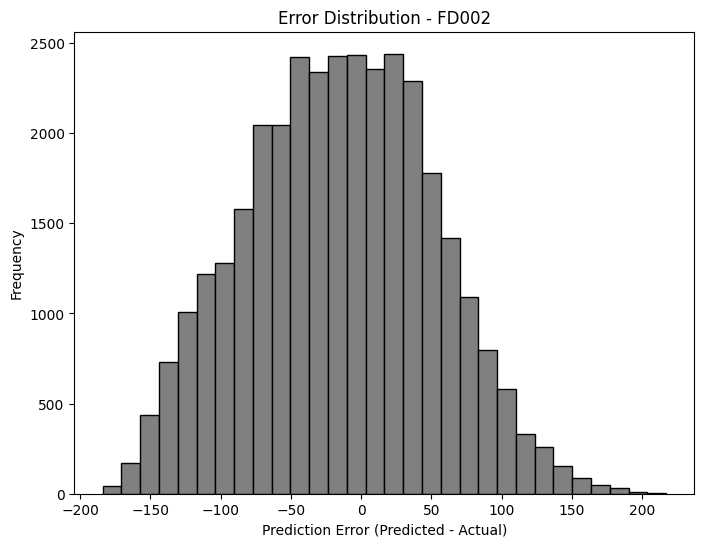

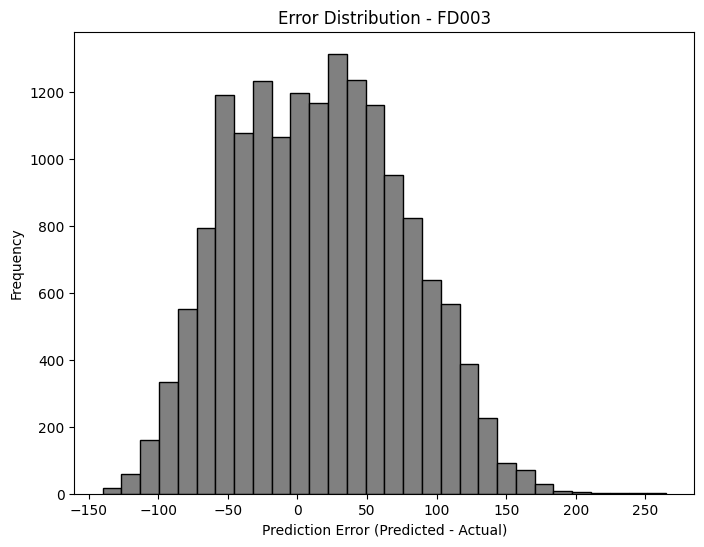

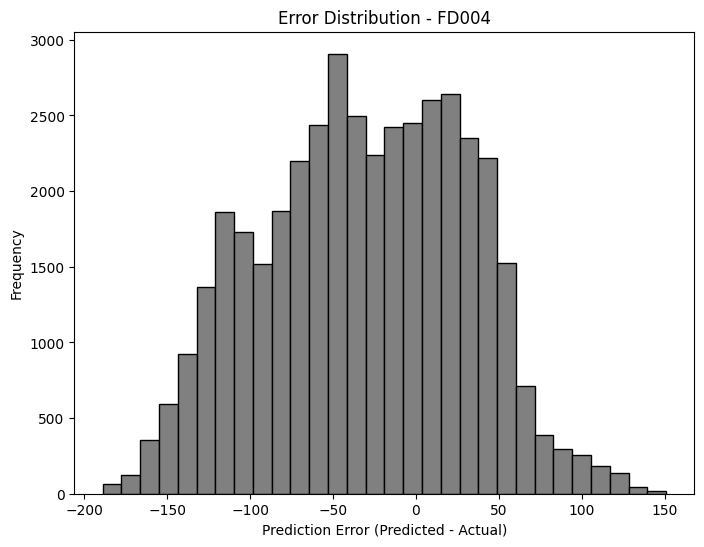

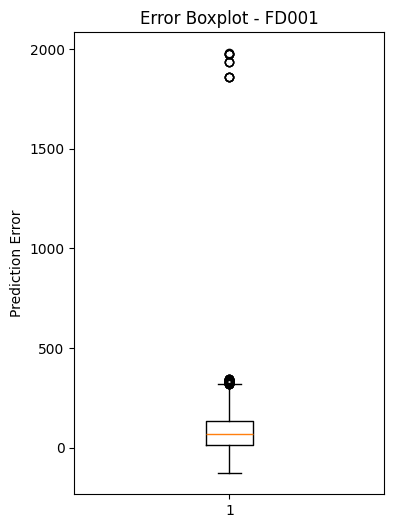

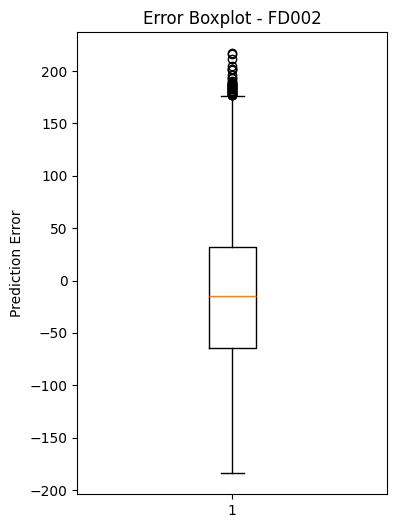

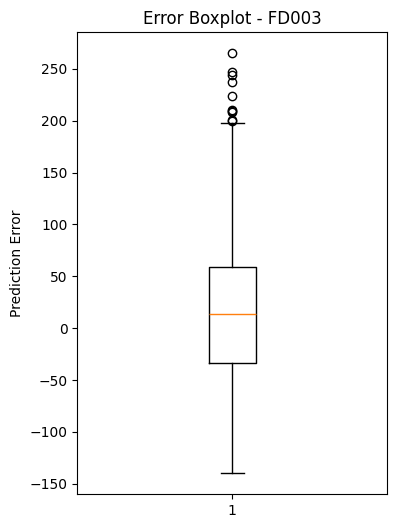

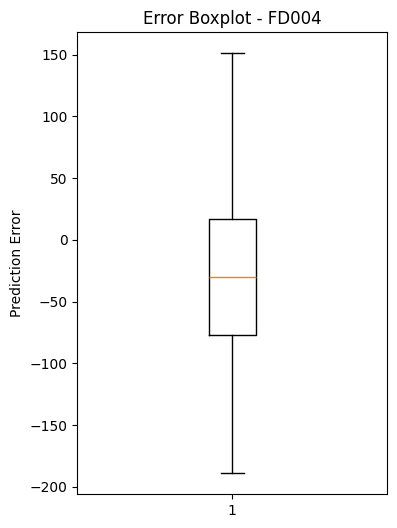

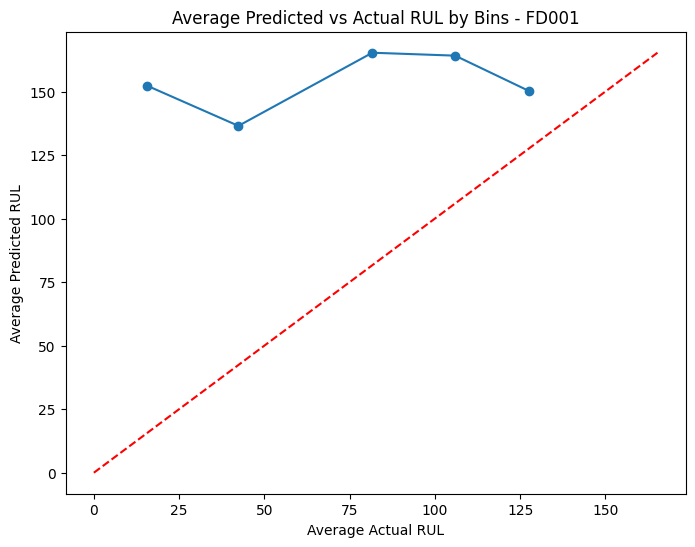

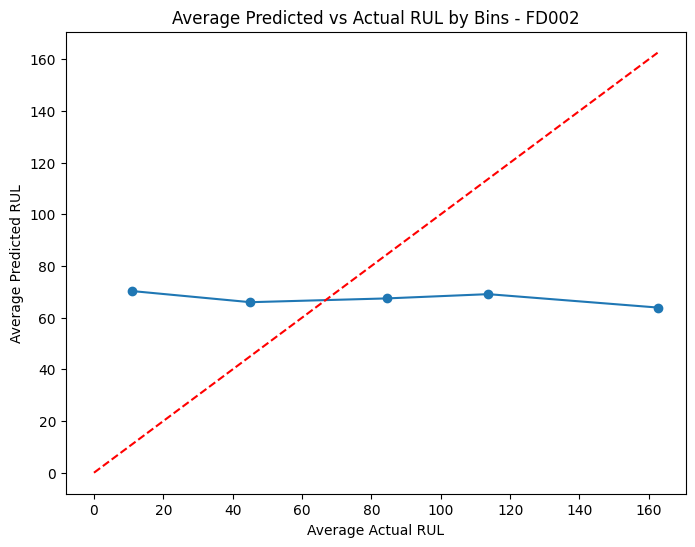

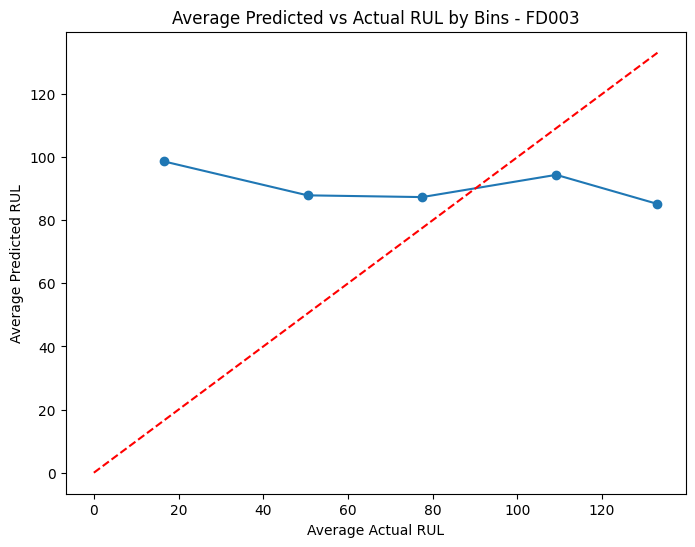

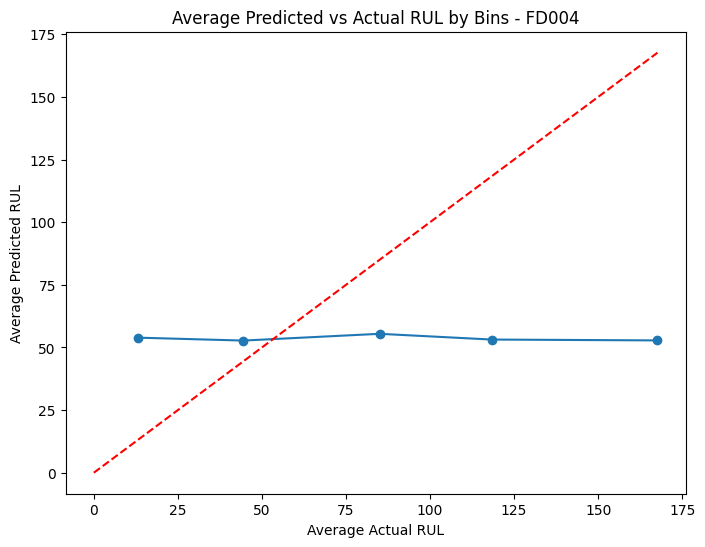

In [8]:
# UPDATED EVALUATION & VISUALIZATION BLOCK

import math
import matplotlib.pyplot as plt
import numpy as np
from lifelines.utils import concordance_index
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay

def categorize_rul_ranges(rul):
    if rul <= 50:
        return "≤50"
    elif rul <= 100:
        return ">50 and ≤100"
    else:
        return ">100"

def evaluate_predictions(pd_test):
    actual = pd_test['RUL'].values
    predicted = pd_test['predicted_RUL'].values

    # Handle infinite predictions if any
    predicted = np.where(np.isinf(predicted), np.nan, predicted)
    max_finite = np.nanmax(predicted)
    predicted = np.where(np.isnan(predicted), max_finite, predicted)

    events = np.ones_like(actual)
    c_index = concordance_index(actual, predicted, event_observed=events)
    mae = np.mean(np.abs(predicted - actual))
    rmse = math.sqrt(mean_squared_error(actual, predicted))

    actual_cats = pd_test['RUL'].apply(categorize_rul_ranges)
    pred_cats = pd.Series(predicted).apply(categorize_rul_ranges)

    labels = ["≤50", ">50 and ≤100", ">100"]
    cm = confusion_matrix(actual_cats, pred_cats, labels=labels)
    return c_index, mae, rmse, cm, labels

def plot_confusion_matrix_ranges(cm, labels, title="Confusion Matrix"):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(title)
    plt.xlabel("Predicted RUL Range")
    plt.ylabel("Actual RUL Range")
    plt.show()

def plot_survival_curves(cox_model, pd_test, title_prefix):
    sample = pd_test.head(3)
    if sample.empty:
        print(f"No data for {title_prefix} survival curves.")
        return
    surv_curves = cox_model.predict_survival_function(sample)
    plt.figure(figsize=(8,6))
    for i, col in enumerate(surv_curves.columns):
        plt.plot(surv_curves.index, surv_curves[col], label=f'Unit {sample["unit_number"].iloc[i]}')
    plt.title(f"{title_prefix}: Predicted Survival Curves (Sample Units)")
    plt.xlabel("Time")
    plt.ylabel("Survival Probability")
    plt.legend()
    plt.show()

def plot_predicted_vs_actual_cox(pd_test, subset_name):
    plt.figure(figsize=(6,6))
    plt.scatter(pd_test['RUL'], pd_test['predicted_RUL'], alpha=0.5)
    max_val = max(pd_test['RUL'].max(), pd_test['predicted_RUL'].max())
    plt.plot([0, max_val],[0, max_val], 'r--')
    plt.title(f"Cox Model - {subset_name}: Predicted vs Actual RUL (Median)")
    plt.xlabel("Actual RUL")
    plt.ylabel("Predicted RUL (Median)")
    plt.show()

def plot_error_distribution(pd_test, subset_name):
    errors = pd_test['predicted_RUL'] - pd_test['RUL']
    plt.figure(figsize=(8,6))
    plt.hist(errors, bins=30, color='gray', edgecolor='black')
    plt.title(f"Error Distribution - {subset_name}")
    plt.xlabel("Prediction Error (Predicted - Actual)")
    plt.ylabel("Frequency")
    plt.show()

def plot_error_boxplot(pd_test, subset_name):
    errors = pd_test['predicted_RUL'] - pd_test['RUL']
    plt.figure(figsize=(4,6))
    plt.boxplot(errors, vert=True)
    plt.title(f"Error Boxplot - {subset_name}")
    plt.ylabel("Prediction Error")
    plt.show()

def plot_average_predictions(pd_test, subset_name, bins=5):
    pd_test = pd_test.copy()
    pd_test['bin'] = pd.qcut(pd_test['RUL'], bins, duplicates='drop')
    grouped = pd_test.groupby('bin').agg({'RUL':'mean', 'predicted_RUL':'mean'}).reset_index()
    plt.figure(figsize=(8,6))
    plt.plot(grouped['RUL'], grouped['predicted_RUL'], marker='o')
    max_val = max(grouped['RUL'].max(), grouped['predicted_RUL'].max())
    plt.plot([0, max_val],[0, max_val],'r--')
    plt.title(f"Average Predicted vs Actual RUL by Bins - {subset_name}")
    plt.xlabel("Average Actual RUL")
    plt.ylabel("Average Predicted RUL")
    plt.show()

# Evaluate all subsets
subsets = ["FD001", "FD002", "FD003", "FD004"]
test_dfs = [cox_test_fd001, cox_test_fd002, cox_test_fd003, cox_test_fd004]

c_indexes = []
maes = []
rmses = []

for name, df in zip(subsets, test_dfs):
    c_index, mae, rmse, cm, labels = evaluate_predictions(df)
    c_indexes.append(c_index)
    maes.append(mae)
    rmses.append(rmse)
    print(f"{name} - C-Index: {c_index:.2f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    plot_confusion_matrix_ranges(cm, labels, title=f"Cox {name} Confusion Matrix (RUL Ranges)")

# Assuming cox_test_fd001, cox_test_fd002, cox_test_fd003, cox_test_fd004 are defined
# and we have c_indexes, maes, rmses after evaluation,
# we produce all plots as described in the report.

# Plot survival curves (Figure X)
plot_survival_curves(cox_model_fd001, cox_test_fd001, "Cox FD001")
plot_survival_curves(cox_model_fd002, cox_test_fd002, "Cox FD002")
plot_survival_curves(cox_model_fd003, cox_test_fd003, "Cox FD003")
plot_survival_curves(cox_model_fd004, cox_test_fd004, "Cox FD004")

# Predicted vs actual RUL scatter (Figure Y)
plot_predicted_vs_actual_cox(cox_test_fd001, "FD001")
plot_predicted_vs_actual_cox(cox_test_fd002, "FD002")
plot_predicted_vs_actual_cox(cox_test_fd003, "FD003")
plot_predicted_vs_actual_cox(cox_test_fd004, "FD004")

# C-Index comparison (part of Figure Z)
plt.figure(figsize=(8,6))
plt.bar(subsets, c_indexes, color='green')
plt.title("Cox Models - C-Index Comparison Across Subsets")
plt.xlabel("Subset")
plt.ylabel("C-Index")
plt.show()

# MAE comparison
plt.figure(figsize=(8,6))
plt.bar(subsets, maes, color='purple')
plt.title("Cox Models - MAE Comparison Across Subsets")
plt.xlabel("Subset")
plt.ylabel("MAE")
plt.show()

# RMSE comparison
plt.figure(figsize=(8,6))
plt.bar(subsets, rmses, color='orange')
plt.title("Cox Models - RMSE Comparison Across Subsets")
plt.xlabel("Subset")
plt.ylabel("RMSE")
plt.show()

# Error distribution (Figure A)
plot_error_distribution(cox_test_fd001, "FD001")
plot_error_distribution(cox_test_fd002, "FD002")
plot_error_distribution(cox_test_fd003, "FD003")
plot_error_distribution(cox_test_fd004, "FD004")

# Error boxplots (Figure A, additional detail)
plot_error_boxplot(cox_test_fd001, "FD001")
plot_error_boxplot(cox_test_fd002, "FD002")
plot_error_boxplot(cox_test_fd003, "FD003")
plot_error_boxplot(cox_test_fd004, "FD004")

# Average predictions by bins (Figure B)
plot_average_predictions(cox_test_fd001, "FD001")
plot_average_predictions(cox_test_fd002, "FD002")
plot_average_predictions(cox_test_fd003, "FD003")
plot_average_predictions(cox_test_fd004, "FD004")

